### Programa para ajustar el valor de $n_\mathrm{ISS}$ al histograma de cada antena usando observaciones con subintegraciones

Importamos los paquetes que vamos a usar

In [ ]:
from lmfit import Model
from lmfit import Parameters, fit_report, minimize
from lmfit import Minimizer, Parameters, report_fit
from lmfit.models import ExpressionModel
from scipy.stats import kstest

import astropy
from astropy import stats

import scipy.integrate as integrate

import pypulse as pulsar

import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt     # para graficar

from scipy.optimize import curve_fit

import math
import decimal
import numpy as np
from scipy.special import gamma, factorial
import glob                         # para hacer listas de archivo
import subprocess                   # para usar subprocesos

import os
import shutil

Definimos la PDF y la CDF

In [13]:
def f(x, n, S0):
    
    return [( np.power(x_i * n / S0,n) / (x_i * gamma(n)) )  * np.exp( (-1.0 * x_i * n) / S0 ) for x_i in x]

In [14]:
def f3(x, n, S0):
    
    b=0
    return [norm * ( np.power(x_i * n / S0,n) / (x_i * gamma(n)) )  * np.exp( (-1.0 * x_i * n) / S0 ) + b for x_i in x]

In [15]:
def pdf(x,n, S0):
    
    return ( np.power(x * n / S0,n) / (x * gamma(n)) ) * np.exp( (-1.0 * x * n) / S0 )

In [16]:
def cdf(x,n,S0,range_start,range_end):
    total = integrate.quad(lambda k: pdf(k,n,S0),range_start,range_end)[0]
    values = []
    for value in x:
        integral = integrate.quad(lambda k: pdf(k,n,S0),range_start,value)[0]
        normalized = integral/total
        values.append(normalized)
    return np.array(values)

Cargamos los datos de la S/N de las observaciones

In [54]:
ant = "A1"     # antena usada (A1 o A2)
t_min = 2000   # t_min de las subintegraciones

datafile = "results_" + ant + "_subints_" + str(t_min) + ".txt"
files = np.loadtxt( datafile , skiprows=0 , dtype=str , usecols=(0) )
sn_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(1) )
t_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(2) )

Calculamos los valores de las $S/N$ proyectados al $t_\mathrm{obs}$ máximo

In [55]:
sn = []
#t_max = np.amax(t_obs)
t_max = 216.970971429
print(t_max)

k=0
for k in range(len(files)):

    sn.append(float(sn_obs[k] * math.sqrt(t_max / t_obs[k]) ))


216.970971429


Hacemos un histograma preliminar

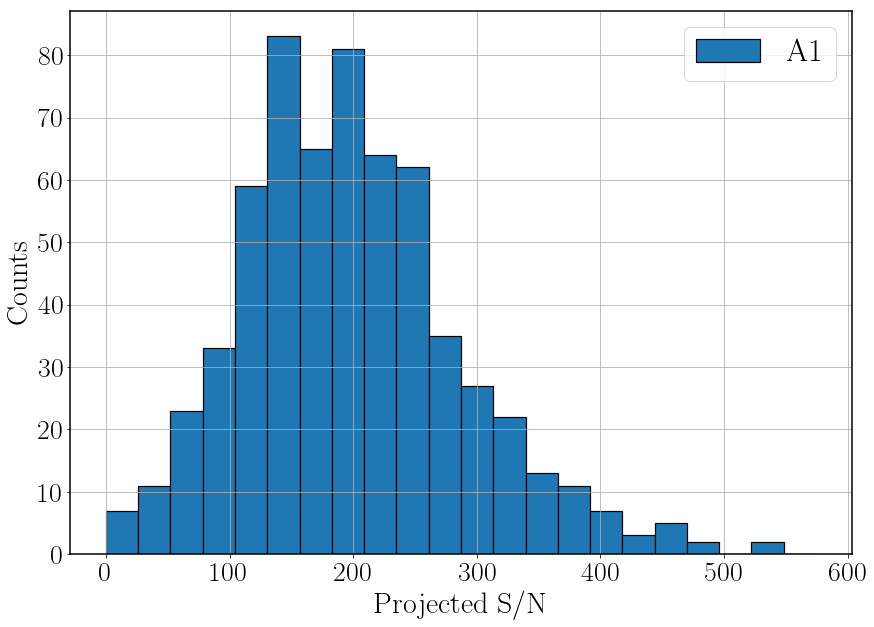

In [56]:
    
plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)

plt.figure(figsize=(14,10))
plt.grid()
    
bin_width = 10

bin_width = astropy.stats.knuth_bin_width(sn,return_bins=False, quiet=True)
bins = np.arange(0, 600 , bin_width)

plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)

plt.legend(loc='upper right')
plt.xlabel('Projected S/N')
plt.ylabel('Counts')
plt.show()

plt.close()

Normalizamos el histograma

In [57]:
bin_heights, bin_borders, _ = plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

norm = np.sum(bin_heights) * (bins[1] - bins[0])
bin_heights_norm = bin_heights / norm

Ajustamos el valor de $n_{\mathrm{ISS}}$

parameter names: ['n']
independent variables: ['x', 'S0']
[[Model]]
    Model(f)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 22
    # variables        = 1
    chi-square         = 2.8246e-06
    reduced chi-square = 1.3451e-07
    Akaike info crit   = -347.099773
    Bayesian info crit = -346.008731
[[Variables]]
    n:  5.49864098 +/- 0.36296408 (6.60%) (init = 2.7)


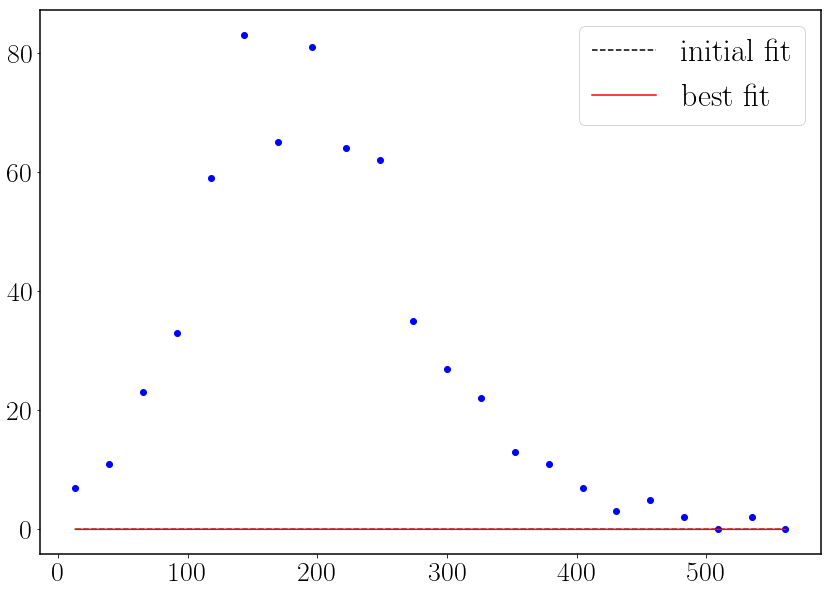

In [58]:
gmodel = Model(f, independent_vars=['x','S0'])
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

params = gmodel.make_params(n=2.7)

S0 = np.mean(sn)

result = gmodel.fit(bin_heights_norm, x=bin_centers, S0=S0, n=2.7)

print(result.fit_report())

plt.close()
plt.figure(figsize=(14,10))
plt.plot(bin_centers, bin_heights, 'bo')
plt.plot(bin_centers, result.init_fit, 'k--', label='initial fit')
plt.plot(bin_centers, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

Realizamos el KS test

In [ ]:
start,end = 0,5000
n = result.best_values.get('n')
data = sn
S0 = np.mean(sn)
res = kstest(data, lambda x: cdf(x,n,S0,start,end))
print(res)

Graficamos el histograma con la curva ajustada

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


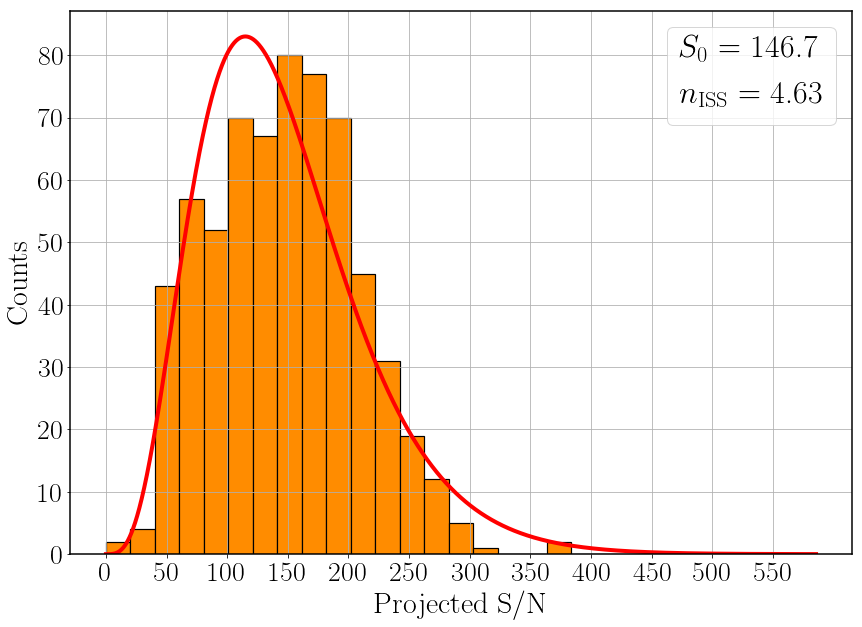

In [53]:
plt.close()

plt.figure(figsize=(14,10))
plt.grid()

if ant == "A1":
    col = "C0" 
elif ant == "A2":
    col = "darkorange"      
elif ant == "A1+A2":
    col = "green"

plt.xticks(np.arange(0, 560 , 50))
    
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

plt.plot(x_interval_for_fit, f3(x_interval_for_fit, result.best_values.get('n'),S0), lw=4, color='red')

plt.bar(bin_centers, bin_heights_norm * norm, width=bin_width, bottom=None, align='center', color=col, edgecolor='black', linewidth=1.2)
plt.plot([], [], ' ', label="$S_0$ = " + str(round(np.mean(sn),2)))
plt.plot([], [], ' ', label="$n_\mathrm{ISS}$ = " + str(round(result.best_values.get('n'),2)))

plt.legend(loc='upper right', handletextpad=0., handlelength=0)

plt.xlabel('Projected S/N')
plt.ylabel('Counts')

plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.pdf', bbox_inches='tight')
plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.png', bbox_inches='tight')

plt.show()
